# ControlNet

ControlNet is an adapter that enables controllable generation such as generating an image of a cat in a specific pose or following the lines in a sketch of a specific cat. It works by adding a smaller network of "zero convolution" layers and progressively training these to avoid disrupting with the original model. The original model parameters are frozen to avoid retraining it.

A ControlNet is conditioned on extra visual information or "structural controls" that can be combined with text prompts to generate images that are guided by the visual input. Examples of structural controls include:

- Canny edge detection
- Depth maps
- Human pose estimation
- And more...

These controls allow for precise guidance in the image generation process, enabling more accurate and controllable results.

paper:https://arxiv.org/abs/2302.05543
huggingface: https://huggingface.co/docs/diffusers/en/using-diffusers/controlnet
controlnet: https://huggingface.co/lllyasviel/ControlNet

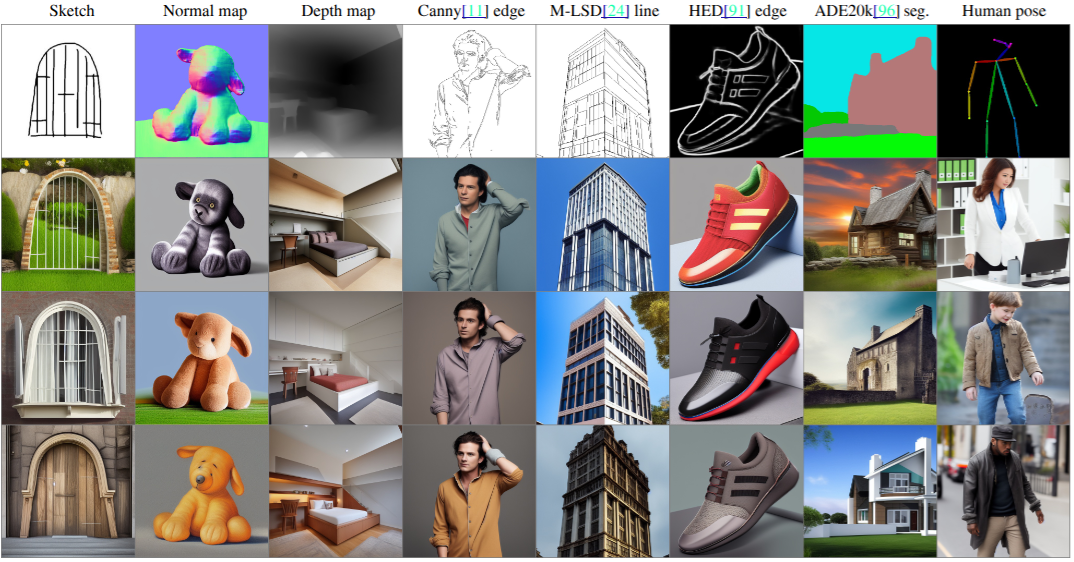

# Using Controlnet as Pipeline

In [1]:
import torch
from diffusers.utils import load_image
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
controlnet_id = 'lllyasviel/control_v11p_sd15_canny'

controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet,safety_checker=None, torch_dtype=torch.float16
).to(device)

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)

c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


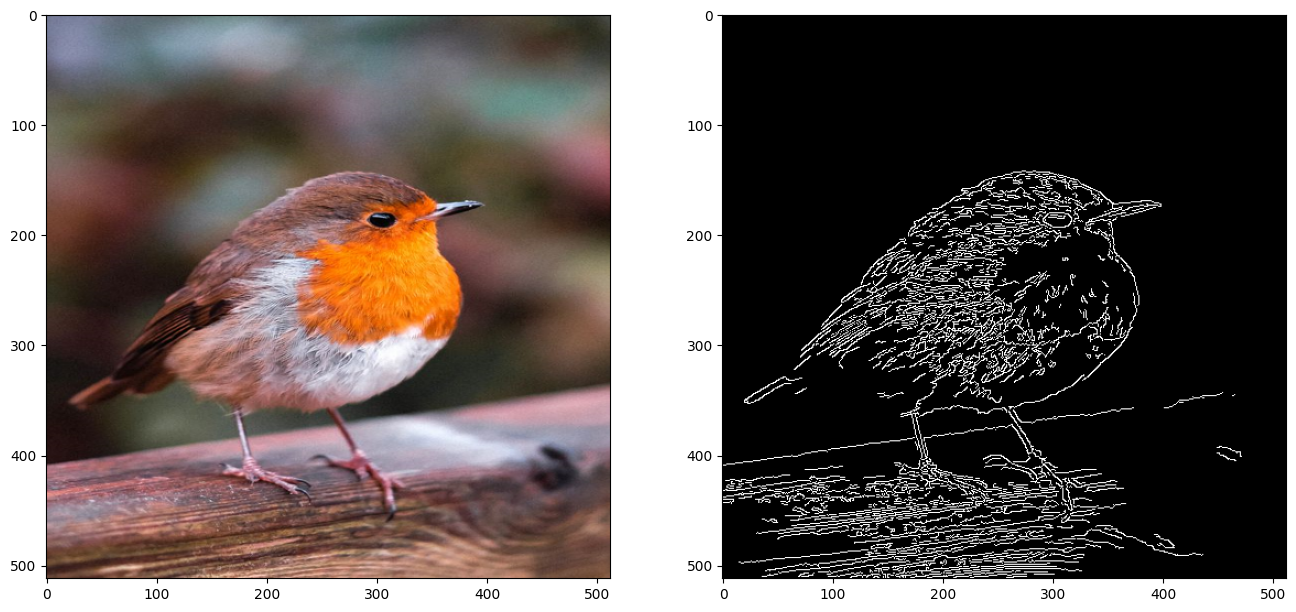

In [4]:
ref_image = load_image(
    "https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/images/input.png"
).resize((512,512))

image = np.array(ref_image)
low_threshold = 100
high_threshold = 200
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(ref_image)
plt.subplot(1,2,2)
plt.imshow(control_image)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

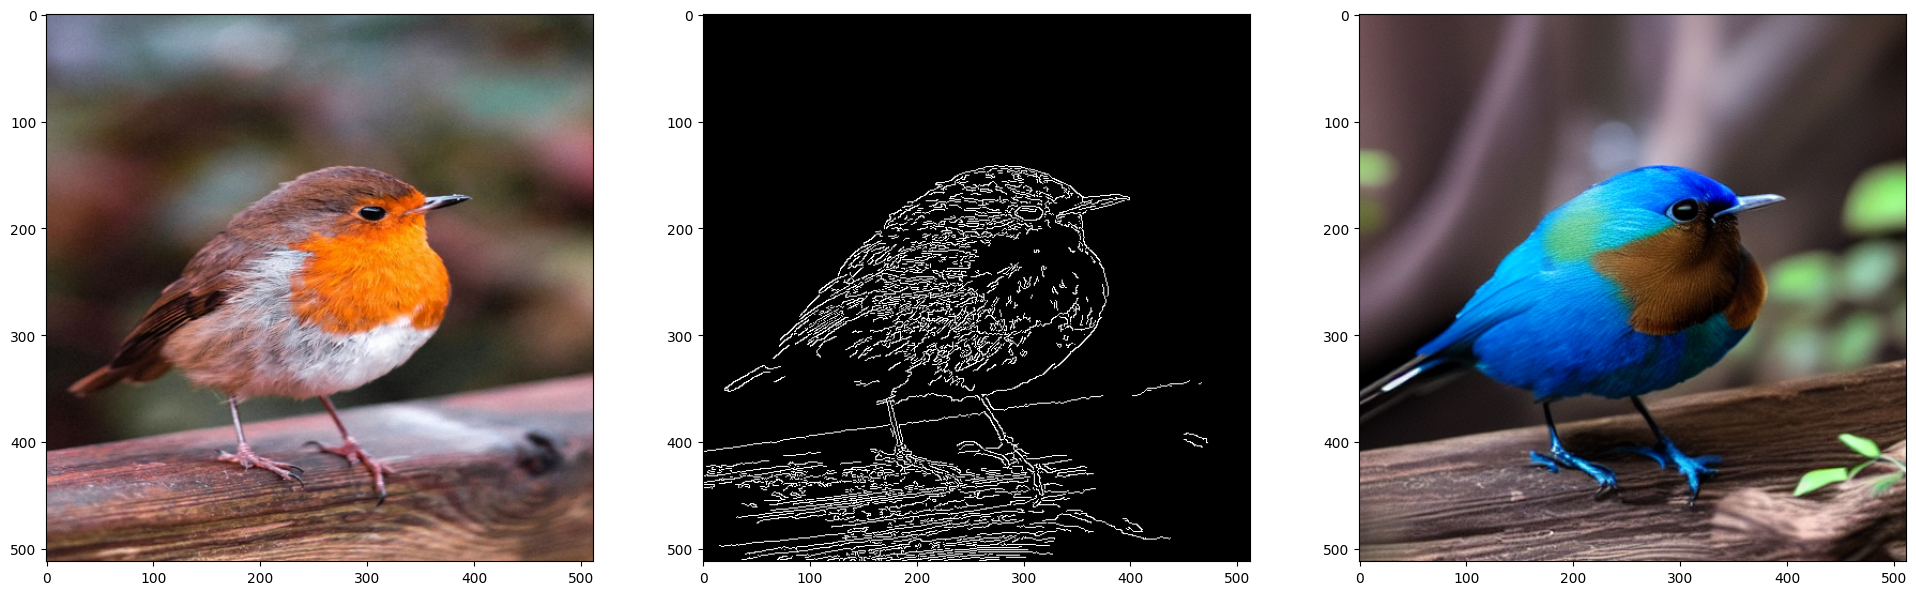

In [5]:
gen_image = pipeline("a blue paradise bird in the jungle",
                  num_inference_steps=20, 
                  image=control_image,
                  generator=torch.manual_seed(33) 
                  ).images[0]

plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(ref_image)
plt.subplot(1,3,2)
plt.imshow(control_image)
plt.subplot(1,3,3)
plt.imshow(gen_image)
plt.show()

# Using different prompts

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

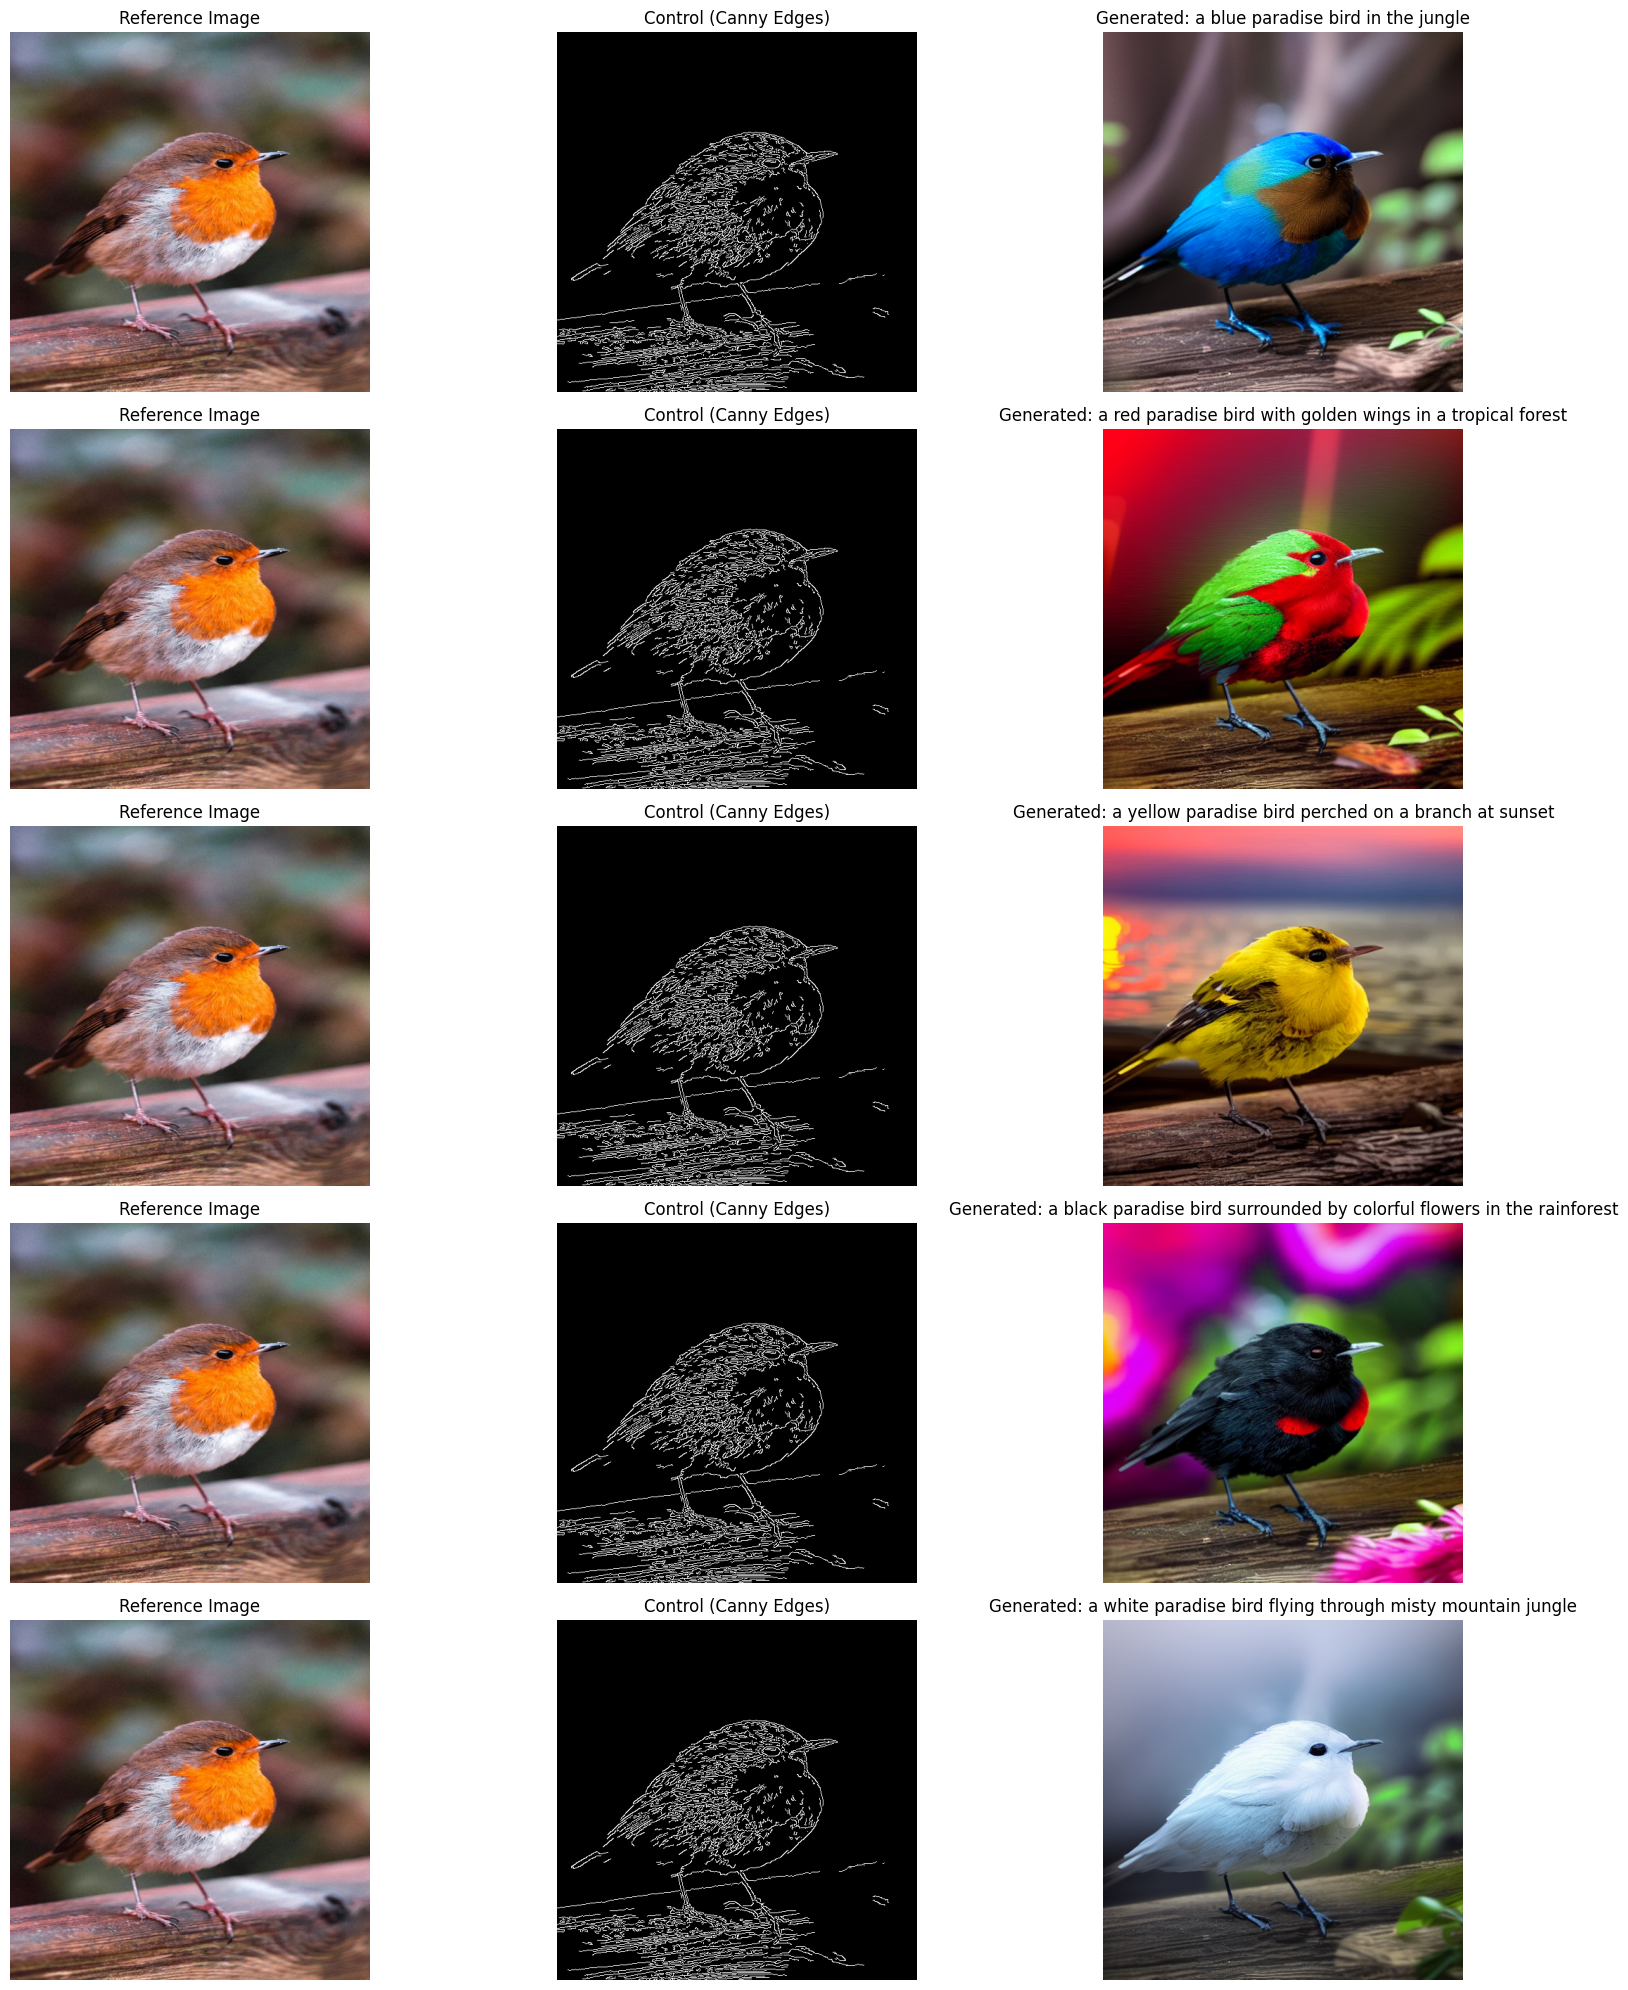

In [6]:
prompts = [
    "a blue paradise bird in the jungle",
    "a red paradise bird with golden wings in a tropical forest",
    "a yellow paradise bird perched on a branch at sunset",
    "a black paradise bird surrounded by colorful flowers in the rainforest",
    "a white paradise bird flying through misty mountain jungle"
]

fig, axes = plt.subplots(5, 3, figsize=(18, 20))

for idx, prompt in enumerate(prompts):
    gen_image = pipeline(prompt,
                      num_inference_steps=20, 
                      image=control_image,
                      generator=torch.manual_seed(33) 
                      ).images[0]
    
    axes[idx, 0].imshow(ref_image)
    axes[idx, 0].set_title("Reference Image")
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(control_image)
    axes[idx, 1].set_title("Control (Canny Edges)")
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(gen_image)
    axes[idx, 2].set_title(f"Generated: {prompt}")
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# How to control the Controlnet Strength

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

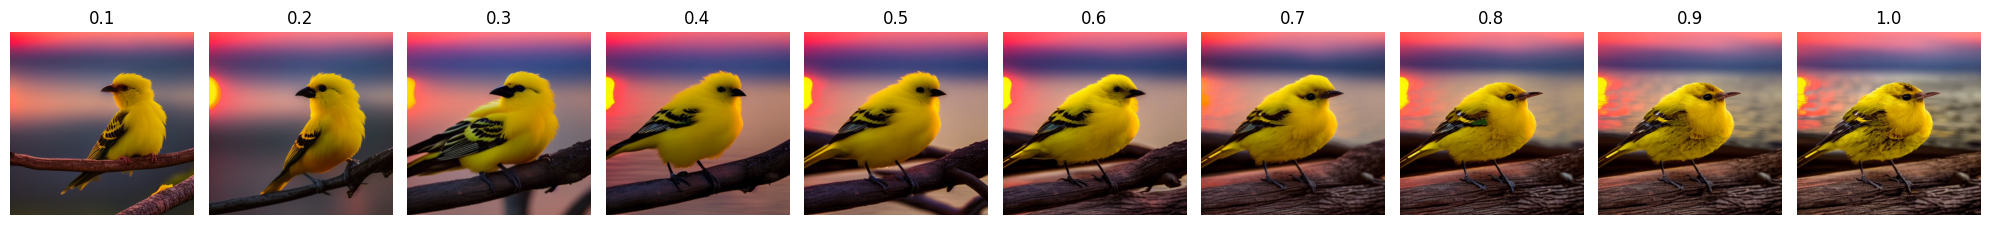

In [9]:
prompt = "a yellow paradise bird perched on a branch at sunset"
    

fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for idx, controlnet_scale in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    gen_image = pipeline(prompt,
                      num_inference_steps=20, 
                      image=control_image,
                      controlnet_conditioning_scale=controlnet_scale,
                      generator=torch.manual_seed(33) 
                      ).images[0]
    
    axes[idx].imshow(gen_image)
    axes[idx].set_title(f"{controlnet_scale}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Controlnet Inpainting

In [1]:
import torch
from diffusers.utils import load_image
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from diffusers import (
    ControlNetModel,
    UniPCMultistepScheduler,
)
from diffusers import StableDiffusionControlNetInpaintPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
controlnet_id = 'lllyasviel/control_v11p_sd15_canny'

controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=torch.float16)

controlnet_inpaint_pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    model_id, controlnet=controlnet,safety_checker=None, torch_dtype=torch.float16).to(device)

controlnet_inpaint_pipeline.scheduler = UniPCMultistepScheduler.from_config(controlnet_inpaint_pipeline.scheduler.config)

c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


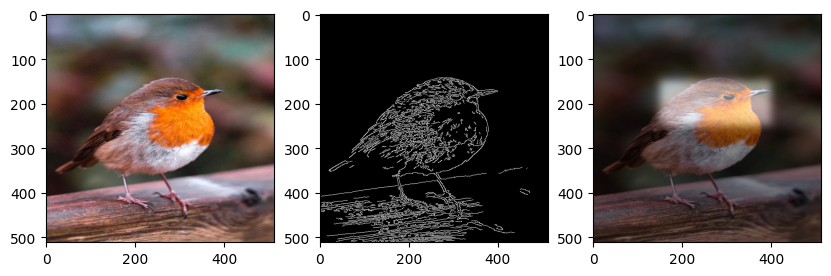

In [2]:
from scipy.ndimage import gaussian_filter
ref_image = load_image(
    "https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/images/input.png"
).resize((512,512))

# Controlnet image creation
image = np.array(ref_image)
low_threshold = 100
high_threshold = 200
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)

# Mask creation
mask = np.zeros((512,512), dtype=np.float32)
mask[150:250, 150:400] = 1.0
mask = gaussian_filter(mask, sigma=10)
mask=Image.fromarray((mask * 255).astype(np.uint8))

plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.imshow(ref_image)
plt.subplot(1,3,2)
plt.imshow(control_image)
plt.subplot(1,3,3)
plt.imshow(ref_image)
plt.imshow(mask,cmap='gray',alpha=0.5)
plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

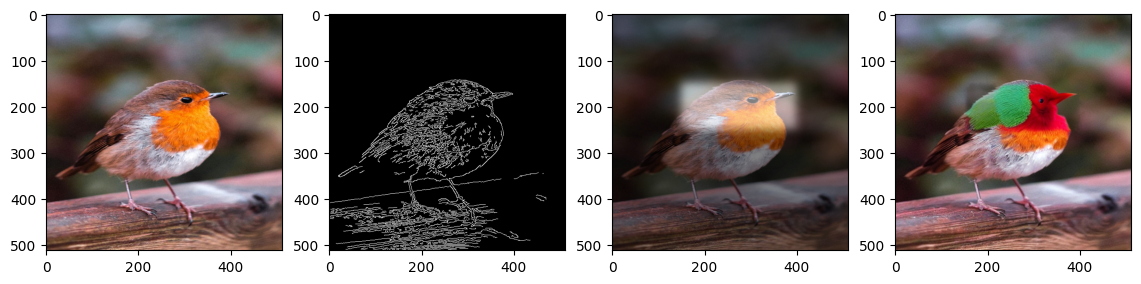

In [5]:
gen_image = controlnet_inpaint_pipeline(
    "a red paradise bird perched on a branch at sunset",
    num_inference_steps=20, 
    image=ref_image,
    mask_image=mask,
    control_image=control_image,
    generator=torch.manual_seed(33) 
).images[0]

plt.figure(figsize=(14,6))
plt.subplot(1,4,1)
plt.imshow(ref_image)
plt.subplot(1,4,2)
plt.imshow(control_image)
plt.subplot(1,4,3)
plt.imshow(ref_image)
plt.imshow(mask,cmap='gray',alpha=0.5)
plt.subplot(1,4,4)
plt.imshow(gen_image)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

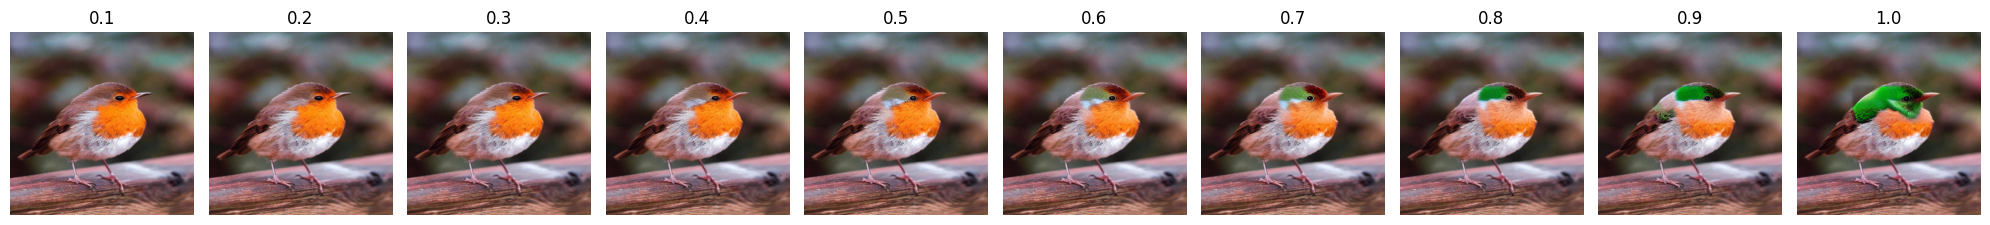

In [6]:
prompt = "a green paradise bird perched on a branch at sunset"
    

fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for idx, strength in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    gen_image = controlnet_inpaint_pipeline(
                                prompt ,
                                num_inference_steps=20, 
                                image=ref_image,
                                mask_image=mask,
                                strength=strength,
                                control_image=control_image,
                                generator=torch.manual_seed(33) 
                            ).images[0]
    
    axes[idx].imshow(gen_image)
    axes[idx].set_title(f"{strength}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Components of Controlnet
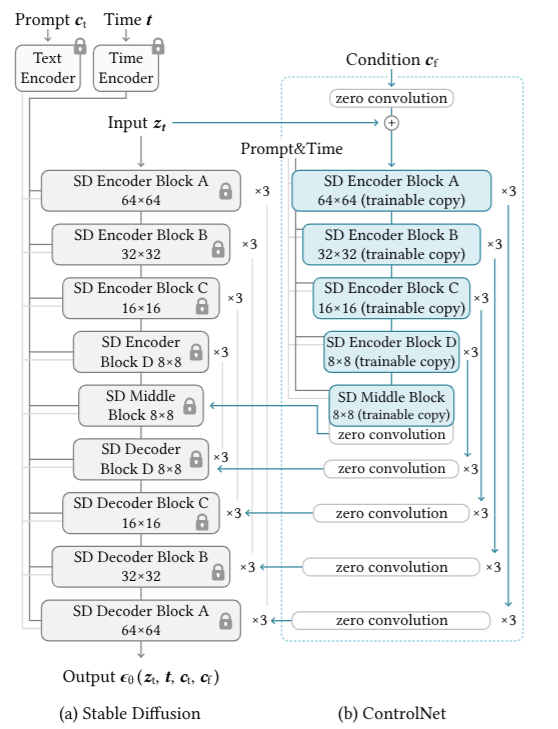

In [1]:
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import CLIPTextModel,CLIPTokenizer
import matplotlib.pyplot as plt

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler
)
from diffusers.utils import load_image


device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float16

c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


In [3]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae",torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet",torch_dtype=dtype)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder",torch_dtype=dtype)

scheduler = UniPCMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

vae.to(device)
unet.to(device)
text_encoder.to(device)

controlnet = ControlNetModel.from_pretrained('lllyasviel/control_v11p_sd15_canny',torch_dtype=dtype)
controlnet.to(device)

`torch_dtype` is deprecated! Use `dtype` instead!


ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [4]:
latent = torch.randn((1,4,64,64)).to(dtype).to(device)
prompt = "a yellow paradise bird perched on a branch at sunset"
tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(tokenized_prompt.input_ids.to(device))[0]
print(f'tokenized_prompt Shape:{tokenized_prompt.input_ids.shape}')
print(f'text_embeddings Shape:{text_embeddings.shape}')

conditioning_image = torch.randn((1,3,512,512)).to(dtype).to(device)

controlnet.eval()
with torch.no_grad():
    down_block_res_samples, mid_block_res_sample = controlnet(sample=latent,
                                                                timestep = 10,
                                                                encoder_hidden_states = text_embeddings,
                                                                controlnet_cond = conditioning_image,
                                                                conditioning_scale=1.0,
                                                                return_dict=False
                                                                )
    
    noise_pred = unet(
                    latent,
                    10,
                    encoder_hidden_states=text_embeddings,
                    down_block_additional_residuals=down_block_res_samples,
                    mid_block_additional_residual=mid_block_res_sample,
                    return_dict=False,
                    )[0]


tokenized_prompt Shape:torch.Size([1, 77])
text_embeddings Shape:torch.Size([1, 77, 768])


In [4]:
print(f'Down blocks')
for sample in down_block_res_samples:
    print(sample.shape)
print('Mid Blocks')
for sample in mid_block_res_sample:
    print(sample.shape)

Down blocks
torch.Size([1, 320, 64, 64])
torch.Size([1, 320, 64, 64])
torch.Size([1, 320, 64, 64])
torch.Size([1, 320, 32, 32])
torch.Size([1, 640, 32, 32])
torch.Size([1, 640, 32, 32])
torch.Size([1, 640, 16, 16])
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 8, 8])
torch.Size([1, 1280, 8, 8])
torch.Size([1, 1280, 8, 8])
Mid Blocks
torch.Size([1280, 8, 8])


## Write the denoising loop manually

### preparing latent, text embeddings

In [5]:
prompt = ["a yellow paradise bird perched on a branch at sunset", ""]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state.to(dtype)

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of  tokenized_prompt: torch.Size([2, 77])
shape of text_embeddings: torch.Size([2, 77, 768])


### preparing the controlnet conditioning

In [6]:
import cv2
from diffusers.image_processor import VaeImageProcessor
control_image_processor = VaeImageProcessor(vae_scale_factor=8, do_convert_rgb=True, do_normalize=False)

ref_image = load_image(
    "https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/images/input.png"
).resize((512,512))

image = np.array(ref_image)
low_threshold = 100
high_threshold = 200
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)

control_image = control_image_processor.preprocess(control_image).to(device).to(dtype)

controlnet_image_cfg = torch.cat([control_image] * 2)

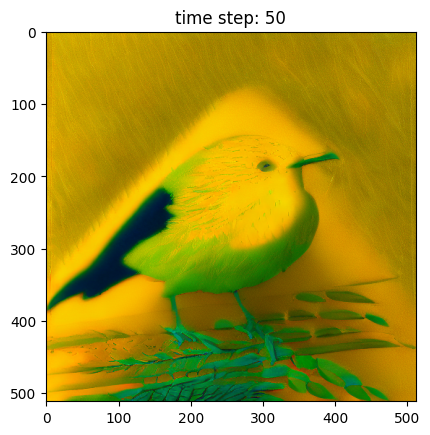

In [7]:
# set the inference time steps to be 50
scheduler.set_timesteps(num_inference_steps=20)

guidance_scale = 7.5

generator = torch.Generator(device=device).manual_seed(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(dtype)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    latent_model_inputs = torch.cat([latents] * 2)
    
    with torch.no_grad():
        # Get Controlnet activations from down and mid blocks
        down_block_res_samples, mid_block_res_sample = controlnet(sample=latent_model_inputs,
                                                                timestep = t,
                                                                encoder_hidden_states = text_embeddings,
                                                                controlnet_cond = controlnet_image_cfg,
                                                                conditioning_scale=0.8,
                                                                return_dict=False
                                                                )
        # predict the noise residual
        noise_pred = unet(latent_model_inputs, 
                          t, 
                          encoder_hidden_states=text_embeddings,
                          down_block_additional_residuals=down_block_res_samples,
                          mid_block_additional_residual=mid_block_res_sample,
                          ).sample # Text conditioning is passed in here
        
    # perform guidance
    noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    extra_step_kwargs = {}
    extra_step_kwargs["generator"] = torch.Generator().manual_seed(42)
    latents = scheduler.step(noise_pred, t, latents, 
                        # generator = generator
                            ).prev_sample
        
    if i%5==0:
        latents_scaled = 1 / vae.config.scaling_factor * latents
        with torch.no_grad():
            image = vae.decode(latents_scaled).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.float().detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        plt.imshow(image)
        plt.title(f'time step: {t}')
        clear_output(wait=True)
        plt.show()
        
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.float().detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()

